In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def circle(nx : int, ny: int, rad: int):
    '''funcion para construir circulos'''
    assert rad < min(nx,ny), 'el circulo debe estar completamente dentro'
    canvas = np.zeros(shape=(nx,ny))
    for i in range(nx):
        for j in range(ny):
            if ((i-nx//2)**2 + (j-ny//2)**2 < rad**2):
                canvas[i,j] = 1
    return np.float32(canvas)

def square(nx : int, ny: int, length: int):
    '''funcion para construir cuadradillos'''
    assert length < min(nx,ny)
    canvas = np.ones(shape=(nx,ny))
    for i in range(nx):
        for j in range(ny):
            if (np.abs(i-nx//2) > length) or (np.abs(j-ny//2) > length):
                canvas[i,j] = 0
    return np.float32(canvas)    

In [3]:
nx = 50
ny = 50
rng = np.random.default_rng()
y_train = rng.integers(0,2,200)
x_train = []
for i in y_train:
    if i == 0:
        x_train.append(circle(nx, ny, rng.integers(1,25)))
    else:
        x_train.append(square(nx, ny, rng.integers(1,25)))

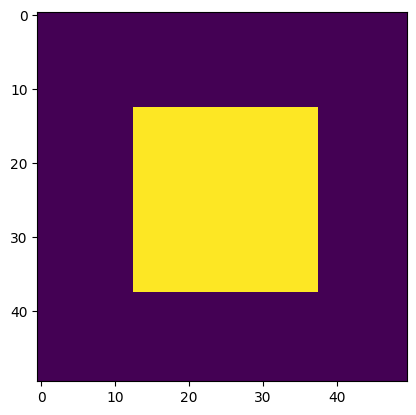

In [4]:
plt.imshow(x_train[0])

In [29]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=8,
                                     kernel_size=(3,3),
                                     padding = (1,1),
                                     stride = (1,1)) 
        self.drop = torch.nn.Dropout(0.25)
        # 8, 50x50
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 8, 25x25
        self.conv2 = torch.nn.Conv2d(in_channels = 8, 
                                     out_channels=16, 
                                     kernel_size=3, 
                                     stride=1, 
                                     padding=1)
        # 16, 25x25
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(2)
        # 16, 12,12 ????
        self.lin   = torch.nn.Linear(in_features = 16*12*12, 
                                     out_features = 2)
        self.sigm  = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = x.flatten(1)
        x = self.lin(x)
        x = self.sigm(x)
        return x

In [30]:
modelito = Model()
pred = modelito(torch.from_numpy(x_train[0]).view(1,1,50,50))
print(pred)

tensor([[0.4597, 0.5262]], grad_fn=<SigmoidBackward0>)


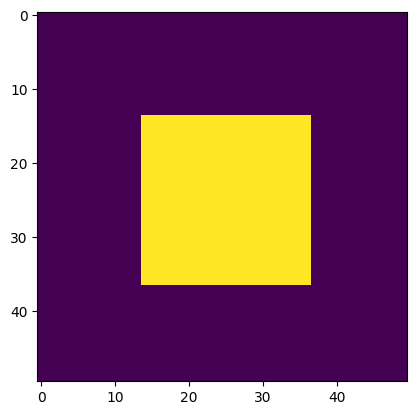

In [31]:
plt.imshow(x_train[1])

In [32]:
labels = np.array([[1,0],[0,1]],dtype=np.float32)
y_train_1 = np.array([labels[0] if e == 0 else labels[1] for e in y_train])
print(np.array(x_train).shape, y_train_1.shape)

(200, 50, 50) (200, 2)


In [33]:
x_train_1 = torch.from_numpy(np.array(x_train, dtype=np.float32)).view(200,1,50,50)
y_train_1 = torch.from_numpy(y_train_1)
print(x_train_1.shape, y_train_1.shape)

torch.Size([200, 1, 50, 50]) torch.Size([200, 2])


In [44]:
criterio = torch.nn.MSELoss()
opt = torch.optim.Adam(modelito.parameters(), lr = 0.001)
hist = []

In [47]:
for e in range(100):
    ypred = modelito(x_train_1)
    loss = criterio(ypred, y_train_1)

    opt.zero_grad()
    loss.backward()
    opt.step()
    hist.append(loss.item())

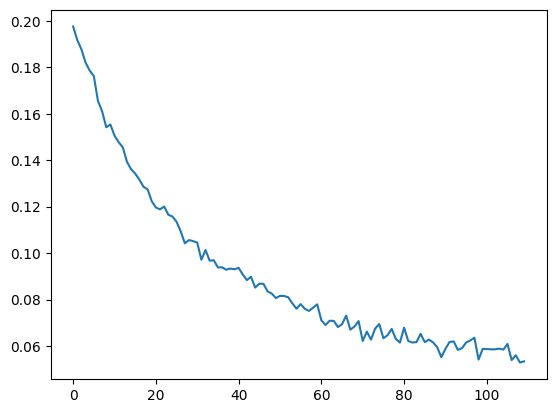

In [48]:
plt.plot(hist)

In [61]:
test = square(nx, ny, rng.integers(1,25))

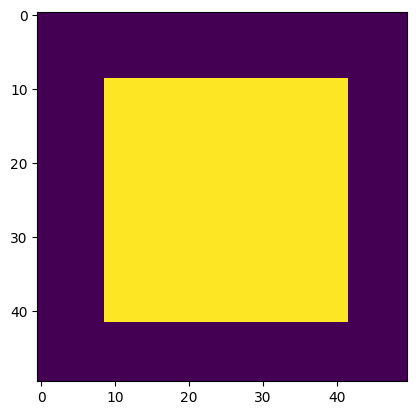

In [62]:
plt.imshow(test)

In [63]:
modelito(torch.from_numpy(test.reshape(1,1,50,50)))

tensor([[7.2558e-05, 1.0000e+00]], grad_fn=<SigmoidBackward0>)